# <ins> BINARY SEMANTIC SEGMENTATION

In [20]:
import monai
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchmetrics

In [2]:
# Generate synthetic 3D data
np.random.seed(42)

mask1 = monai.data.create_test_image_3d(height=32, width=256, depth=256, num_objs=100, rad_max=15)[0]
mask1[mask1 != 0] = 1

mask2 = monai.data.create_test_image_3d(height=32, width=256, depth=256, num_objs=100, rad_max=15)[0]
mask2[mask2 != 0] = 1

mask1 = torch.tensor(mask1)
mask2 = torch.tensor(mask2)

mask1.shape, mask2.shape

(torch.Size([32, 256, 256]), torch.Size([32, 256, 256]))

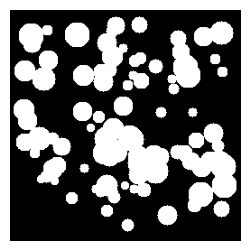

In [3]:
plt.figure(figsize=(3, 3))
plt.imshow(mask1[15, ...], cmap='gray')
plt.axis('off')
plt.show()

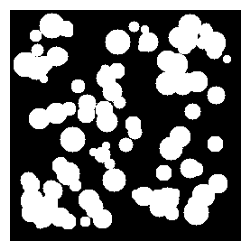

In [4]:
plt.figure(figsize=(3, 3))
plt.imshow(mask2[15, ...], cmap='gray')
plt.axis('off')
plt.show()

In [89]:
def simple_dice(a, b):
    intersection = torch.sum(a * b)
    union = torch.sum(a) + torch.sum(b)
    if union == 0:
        union = 1e-6
    dice = 2 * intersection / union
    
    return round(dice.item(), 4)

In [90]:
simple_dice(mask1, mask1), simple_dice(mask1, mask2)

(1.0, 0.3185)

In [91]:
dice_monai = monai.metrics.DiceMetric(include_background=False, num_classes=1)

In [17]:
dice_monai(
    y_pred = mask1[None, None, ...], # shape = [B, C, D, H, W], where B = batch dimension, C = class channels dimension
    y = mask1[None, None, ...]
)

tensor([[1.]])

In [92]:
dice_monai(
    y_pred = mask1[None, None, ...], # shape = [B, C, D, H, W]
    y = mask2[None, None, ...]
)

tensor([[0.3185]])

In [66]:
dice_torch = torchmetrics.Dice()

In [67]:
dice_torch(
    preds = mask1[None, None, ...],
    target = mask2[None, None, ...].type(torch.int8)
)

tensor(0.3185)

Batch

In [148]:
def create_synt_mask():
    '''Final shape = [B, D, H, W]
    '''
    mask = monai.data.create_test_image_3d(channel_dim=0, height=32, width=256, depth=256, num_objs=100, rad_max=15)[0]
    mask[mask != 0] = 1
    return torch.tensor(mask)

In [155]:
np.random.seed(54)
batch1 = torch.concatenate([create_synt_mask() for i in range(4)])
batch2 = torch.concatenate([create_synt_mask() for i in range(4)])

batch1.shape, batch2.shape

(torch.Size([4, 32, 256, 256]), torch.Size([4, 32, 256, 256]))

In [156]:
batch1.sum(), batch2.sum()

(tensor(1537798.), tensor(1497427.))

In [157]:
# Compute dice for entire batch as whole
simple_dice(batch1, batch1), simple_dice(batch1, batch2)

# (1.0, 0.3322)

(1.0, 0.3322)

In [158]:
# Compute dice separately per image
dices = []
for i in range(4):
    dice = simple_dice(batch1[i], batch1[i])
    dices.append(dice)
    
print(dices)
print(np.mean(dices))

dices = []
for i in range(4):
    dice = simple_dice(batch1[i], batch2[i])
    dices.append(dice)
    
print(dices)
print(round(np.mean(dices), 4))

# [1.0, 1.0, 1.0, 1.0]
# 1.0
# [0.3396, 0.3168, 0.3451, 0.3252]
# 0.3317

[1.0, 1.0, 1.0, 1.0]
1.0
[0.3396, 0.3168, 0.3451, 0.3252]
0.3317


Computing the dice for the entire batch as a whole and separately for each sample and then do the average lead to (a bit) different results. This corresponds to `torchmetrics.Dice`'s `average` parameter's arguments `'micro'` and `'samples'`.

In [159]:
dice_torch = torchmetrics.Dice(average='micro')
dice_torch(preds=batch1, target=batch1.type(torch.int8)), dice_torch(preds=batch1, target=batch2.type(torch.int8))

# (tensor(1.), tensor(0.3322))

(tensor(1.), tensor(0.3322))

In [160]:
dice_torch = torchmetrics.Dice(average='samples')
dice_torch(preds=batch1, target=batch1.type(torch.int8)), dice_torch(preds=batch1, target=batch2.type(torch.int8))

# (tensor(1.), tensor(0.3317))

(tensor(1.), tensor(0.3317))

In [162]:
# If I add a class dimension, the results are the same.
dice_torch = torchmetrics.Dice(average='micro')
print(dice_torch(preds=batch1[:, None, ...], target=batch1[:, None, ...].type(torch.int8)))
print(dice_torch(preds=batch1[:, None, ...], target=batch2[:, None, ...].type(torch.int8)))

tensor(1.)
tensor(0.3322)


In [163]:
dice_torch = torchmetrics.Dice(average='samples')
print(dice_torch(preds=batch1[:, None, ...], target=batch1[:, None, ...].type(torch.int8)))
print(dice_torch(preds=batch1[:, None, ...], target=batch2[:, None, ...].type(torch.int8)))

tensor(1.)
tensor(0.3317)


In [185]:
# Monai however always require the channel dimension
dice_monai = monai.metrics.DiceMetric(include_background=False, num_classes=1)

In [188]:
dice_monai(batch1[:, None, ...], batch1[:, None, ...])

tensor([[1.],
        [1.],
        [1.],
        [1.]])

In [189]:
dice_monai(batch1[:, None, ...], batch2[:, None, ...])

tensor([[0.3396],
        [0.3168],
        [0.3451],
        [0.3252]])

Monai retuns the metric per sample in the batch, then we have to apply compute the average to get a metric on the batch.

In [190]:
dice_monai(batch1[:, None, ...], batch2[:, None, ...]).mean()

tensor(0.3317)

# <ins> MULTICLASS SEMANTIC SEGMENTATION

- A model outputs logits --> logits are turned to probabilities across classes by softmax --> Dice metric is computed with these probs.
- DO NOT apply thresholding to these probs to turn them into a binary prediction for Dice loss computation. It's ok to do this for Dice metric computation.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
# Load GT and PRED, where PRED is a slightly tilted version of GT, hence a good prediction
# Both are as binary masks
gt_arr, pred_arr = np.load('data/multiclass_semantic_segm.npy')
gt_arr.shape, pred_arr.shape

((256, 256, 6), (256, 256, 6))

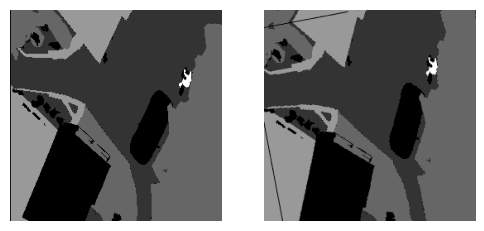

In [3]:
# Plot images
v = np.array([0, 1, 2, 3, 4, 5])
v = v[np.newaxis, np.newaxis, :] # add H and W dims

gt_image = np.sum(gt_arr * v, axis=2) * 25
pred_image = np.sum(pred_arr * v, axis=2) * 25

fig, ax = plt.subplots(1, 2, figsize=(6, 10))
ax[0].imshow(gt_image, cmap='gray')
ax[0].axis('off')
ax[1].imshow(pred_image, cmap='gray')
ax[1].axis('off')
plt.show()

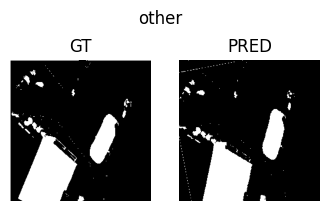

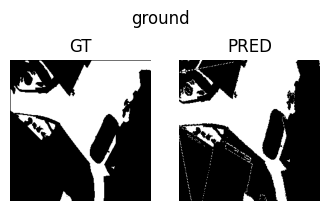

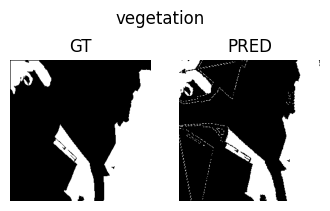

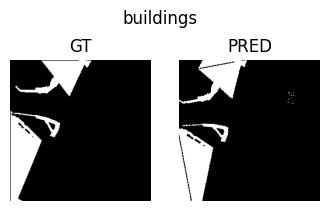

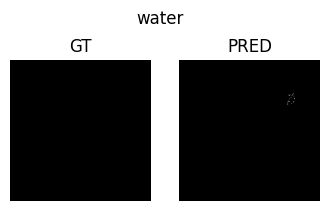

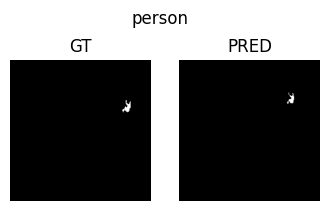

In [4]:
# Plot category channels
category_ids = {'other': 0, 'ground': 1, 'vegetation': 2, 'buildings': 3, 'water': 4, 'person': 5}

for category, category_id in category_ids.items():
    fig, ax = plt.subplots(1, 2, figsize=(4, 2.5))
    ax[0].imshow(gt_arr[..., category_id], cmap='gray')
    ax[0].axis('off')
    ax[0].set_title('GT')
    ax[1].imshow(pred_arr[..., category_id], cmap='gray')
    ax[1].axis('off')
    ax[1].set_title('PRED')
    fig.suptitle(category)
    plt.show()
    
# There are some artifacts in the predictions, but they can be ignored.

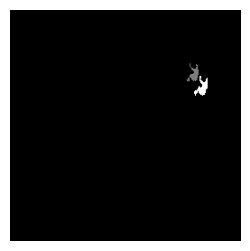

In [5]:
# Prediction (in grey) for class 5 is actually a bad prediction, so a low Dice is expected.
a = gt_arr[..., 5] * 255 + pred_arr[..., 5] * 125

plt.figure(figsize=(3, 3))
plt.imshow(a, cmap='gray')
plt.axis('off')
plt.show()

In [6]:
# To tensors and reshape
gt = torch.tensor(gt_arr.transpose(2, 0, 1))
pred_mask = torch.tensor(pred_arr.transpose(2, 0, 1))

# Add batch dimension
gt = gt[None, ...].type(torch.float32)
pred_mask = pred_mask[None, ...].type(torch.float32)

# Simulate a batch of 2
gt = torch.concatenate([gt, gt])
pred = torch.concatenate([pred_mask, pred_mask])

gt.shape, pred_mask.shape

(torch.Size([2, 6, 256, 256]), torch.Size([1, 6, 256, 256]))

In [7]:
# PRED is binary, so let's simulate some real prediction by the model, which should be as 
# probabilities: prob=0.95 for the right class and 0.01 for the others, so still a good prediction
pred = torch.where(pred_mask == 1, 0.95, 0.01)

In [8]:
# Compute Dice for all classes and all data together
epsilon = 1e-6
intersection = (gt * pred).sum() + epsilon
union = (gt + pred).sum() + epsilon
dice = 2 * intersection / union
dice  

tensor(0.6886)

In [9]:
# Compute Dice separately by class and data, then take the average for the batch
intersection = torch.sum(gt * pred, dim=[2, 3]) + epsilon
union = torch.sum(gt + pred, dim=[2, 3]) + epsilon

dice_per_image_and_class = 2 * intersection / union
dice_per_image_and_class = torch.round(dice_per_image_and_class, decimals=4)
print(dice_per_image_and_class)

dice_per_image = torch.mean(dice_per_image_and_class, axis=1)
print(dice_per_image)

dice_batch = dice_per_image.mean()
dice_batch

tensor([[0.6458, 0.7161, 0.7524, 0.5935, 0.0000, 0.0033],
        [0.6458, 0.7161, 0.7524, 0.5935, 0.0000, 0.0033]])
tensor([0.4519, 0.4519])


tensor(0.4519)

In [10]:
# PROBLEM
# GT channel 4 is empty, that is there are no objects of class 4.
# PRED channel 4 is also empty (it has very low values actually), so the model did a good job
# to not predict any objects of this class, but the Dice for channel 4 is 0, and this is a problem
# that needs to be dealt with.

# SOLUTION
# If GT of a class is empty, assign to that chanhel weight=0 in the Dice computation. This is the
# only method I found that keeps the Dice function differentiable. A drawback is that, when GT for
# that chanel is empty but the model wrongly predicts some objects, this error is not penalized by
# this version of the Dice loss. Hopefully, the model will be penalized for its FPs in that class 
# while training on the other data.

In [11]:
intersection = torch.sum(gt * pred, dim=[2, 3]) + epsilon
union = torch.sum(gt + pred, dim=[2, 3]) + epsilon

dice_per_image_and_class = 2 * intersection / union
dice_per_image_and_class = torch.round(dice_per_image_and_class, decimals=4)
print(dice_per_image_and_class)

weights = (torch.sum(gt != 0, axis=[2, 3]) != 0).type(torch.float32)
print(weights)

weighted_dice_per_image = torch.sum(dice_per_image_and_class * weights, axis=1) / torch.sum(weights, axis=1)
print(weighted_dice_per_image)

dice_batch = weighted_dice_per_image.mean()
dice_batch

# it's higher, as expected.

tensor([[0.6458, 0.7161, 0.7524, 0.5935, 0.0000, 0.0033],
        [0.6458, 0.7161, 0.7524, 0.5935, 0.0000, 0.0033]])
tensor([[1., 1., 1., 1., 0., 1.],
        [1., 1., 1., 1., 0., 1.]])
tensor([0.5422, 0.5422])


tensor(0.5422)

In [21]:
# Check that the function is differentiable
def my_dice(prediction, ground_truth, epsilon=1e-6):
    intersection = torch.sum(ground_truth * prediction, dim=[2, 3]) + epsilon
    union = torch.sum(ground_truth + prediction, dim=[2, 3]) + epsilon
    dice_per_image_and_class = 2 * intersection / union
    weights = (torch.sum(ground_truth != 0, axis=[2, 3]) != 0).type(torch.float32)
    weighted_dice_per_image = torch.sum(dice_per_image_and_class * weights, axis=1) / torch.sum(weights, axis=1)
    dice_batch = weighted_dice_per_image.mean()
    
    return dice_batch


dummy_pred = torch.rand(5, 3, 256, 256, requires_grad=True)
dummy_gt = torch.rand(5, 3, 256, 256)
dummy_dice = my_dice(dummy_pred, dummy_gt)
dummy_dice.backward()

differentiable = dummy_pred.grad is not None
differentiable    

True

In [12]:
# TODO: define class